In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(".."))
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import scienceplots


from cmap import Colormap
plt.rcParams['image.cmap']= 'cividis'
cmap = Colormap('seaborn:icefire').to_mpl()
device = "cuda"

In [2]:
# Shape [B,C,D,n_t, M]
truth = np.load("trajectories/Burgers_truth.npy")
deterministic = np.load("trajectories/Burgers_deterministic.npy")
normal = np.load("trajectories/Burgers_normal.npy")
mixednormal = nuth = np.load("trajectories/Burgers_mixednormal.npy")
mvnormal = np.load("trajectories/Burgers_mvnormal.npy")
sample = np.load("trajectories/Burgers_sample.npy")

In [3]:
ticksize = 29
legendsize = 32
axissize = 31
titlesize = 34
plt.style.use(["science"])

# Multiple plots

In [4]:
def plot_predictions(truth, pred,name, b=4, s=25):

    fig = plt.figure(figsize=(25, 5))

    # Outer grid: 2 rows × 2 columns
    outer = gridspec.GridSpec(2, 2, figure=fig, width_ratios=[1, 2], wspace=0.1, hspace=0.15)

    # Right block: a 2×2 inside the right column
    right_gs = gridspec.GridSpecFromSubplotSpec(
        2, 2, subplot_spec=outer[:, 1], wspace=0.1, hspace=0.3
    )

    axs = [
        fig.add_subplot(right_gs[0, 0]),
        fig.add_subplot(right_gs[0, 1]),
        fig.add_subplot(right_gs[1, 0]),
        fig.add_subplot(right_gs[1, 1]),
    ]

    cbs = []

    # Left subplot: put in the middle between top and bottom
    # → we compute its size from one right subplot and align manually
    pos_top = axs[0].get_position()
    pos_bottom = axs[2].get_position()

    # Same height as one of the right plots
    height = pos_top.height
    # Same vertical center as the 2×2 block
    center_y = (pos_top.y0 + pos_bottom.y1) / 2

    # Manually add left axis with matching size
    ax_left = fig.add_axes([0.12, center_y - height/2, pos_top.width, height])

    # --- Plots ---
    vmin_truth = -8
    vmax_truth = 1
    im1 = axs[0].pcolormesh(pred[b,0,:,:,s], cmap = cmap, rasterized = True, vmin = vmin_truth, vmax = vmax_truth)
    axs[0].set_title("Sample trajectory", fontsize = titlesize)
    cbs.append(fig.colorbar(im1, ax = axs[0], pad = 0.02))

    im3 = axs[1].pcolormesh((truth[b,0,2:].T-pred[b,0].mean(axis = -1))**2, cmap = cmap, rasterized = True, vmax = 55)
    axs[1].set_title("Squared error", fontsize = titlesize)
    cbs.append(fig.colorbar(im3, ax=axs[1], pad = 0.02))

    im2 = axs[2].pcolormesh(pred[b,0].mean(axis=-1), cmap=cmap, rasterized = True, vmin = vmin_truth, vmax = vmax_truth)
    axs[2].set_title("Mean prediction", fontsize = titlesize)
    cbs.append(fig.colorbar(im2, ax=axs[2], pad = 0.02))

    im4 = axs[3].pcolormesh(pred[b,0].std(axis = -1), cmap="cividis", rasterized = True, vmax = 0.75)
    axs[3].set_title("Standard deviation", fontsize = titlesize)
    cbs.append(fig.colorbar(im4, ax=axs[3], pad = 0.02))

    # Left plot
    im_left = ax_left.pcolormesh(truth[b,0,2:].T, cmap=cmap, rasterized = True, vmin = vmin_truth, vmax = vmax_truth)
    ax_left.set_title("Ground truth", fontsize = titlesize)
    cbs.append(fig.colorbar(im_left, ax=ax_left, pad = 0.02))

    # Add labels
    # Hide x-ticks on the top row
    for ax in [axs[0], axs[1]]:
        ax.set_xticklabels([])
        ax.set_xlabel("")

    # Hide y-ticks on the right column
    for ax in [axs[1], axs[3]]:
        ax.set_yticklabels([])
        ax.set_ylabel("")

    # Add labels only where needed
    axs[2].set_xlabel("s", fontsize = axissize)   # bottom left
    axs[3].set_xlabel("s", fontsize = axissize)   # bottom right
    axs[0].set_ylabel("x", fontsize = axissize)   # top left
    axs[2].set_ylabel("x", fontsize = axissize)   # bottom left

    # Do the same for the left (truth) plot
    ax_left.set_xlabel("s", fontsize = axissize)
    ax_left.set_ylabel("x", fontsize = axissize)

    for ax in [ax_left] + [axs[0], axs[2]]:
        ax.yaxis.set_major_locator(plt.MaxNLocator(3))

    for ax in [ax_left] + axs:
        ax.tick_params(axis="both", which="major", labelsize=ticksize)

    for ax in [ax_left] + [axs[2], axs[3]]:
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))

    for cb in cbs:
        cb.ax.tick_params(labelsize=legendsize)

    plt.savefig(f"plots/Burgers_multiple_{name}.pdf", bbox_inches = "tight")

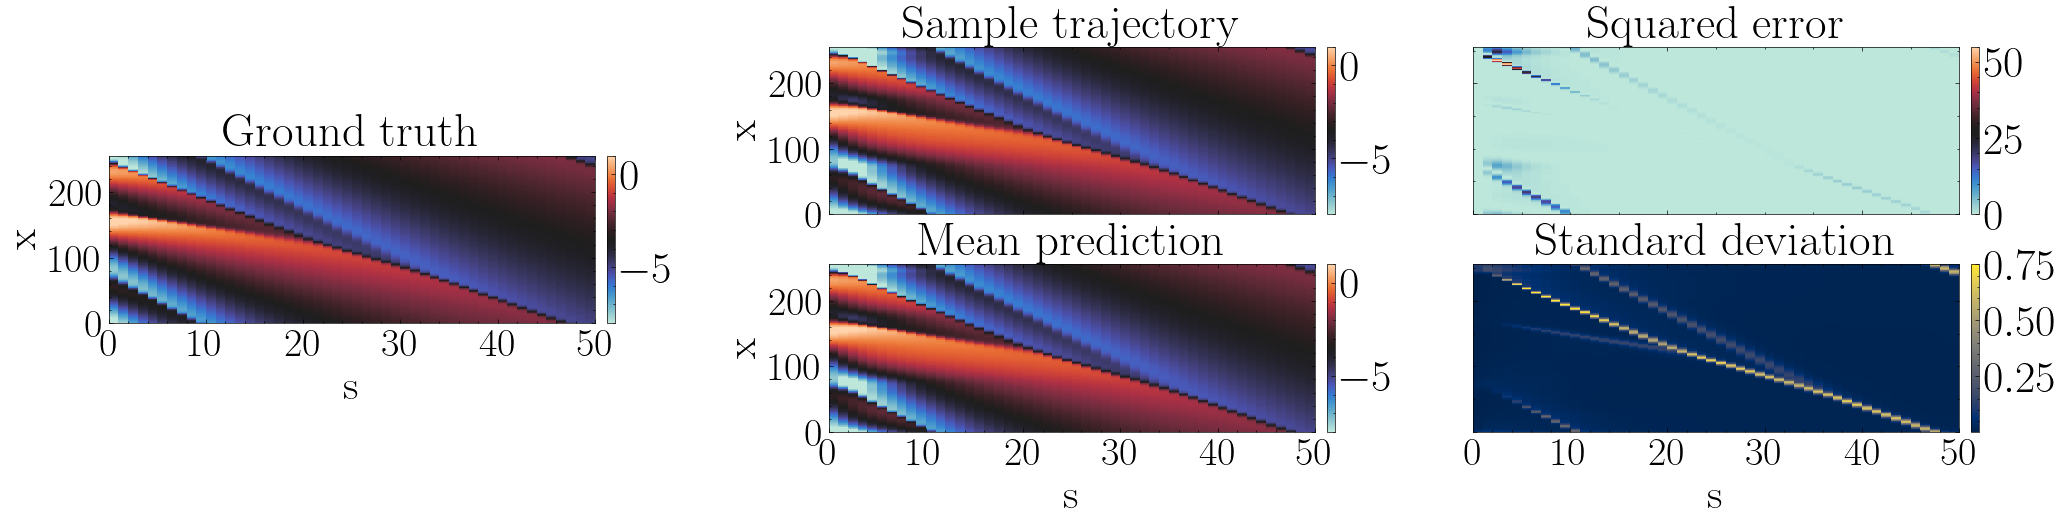

In [5]:
plot_predictions(truth, deterministic, "deterministic")

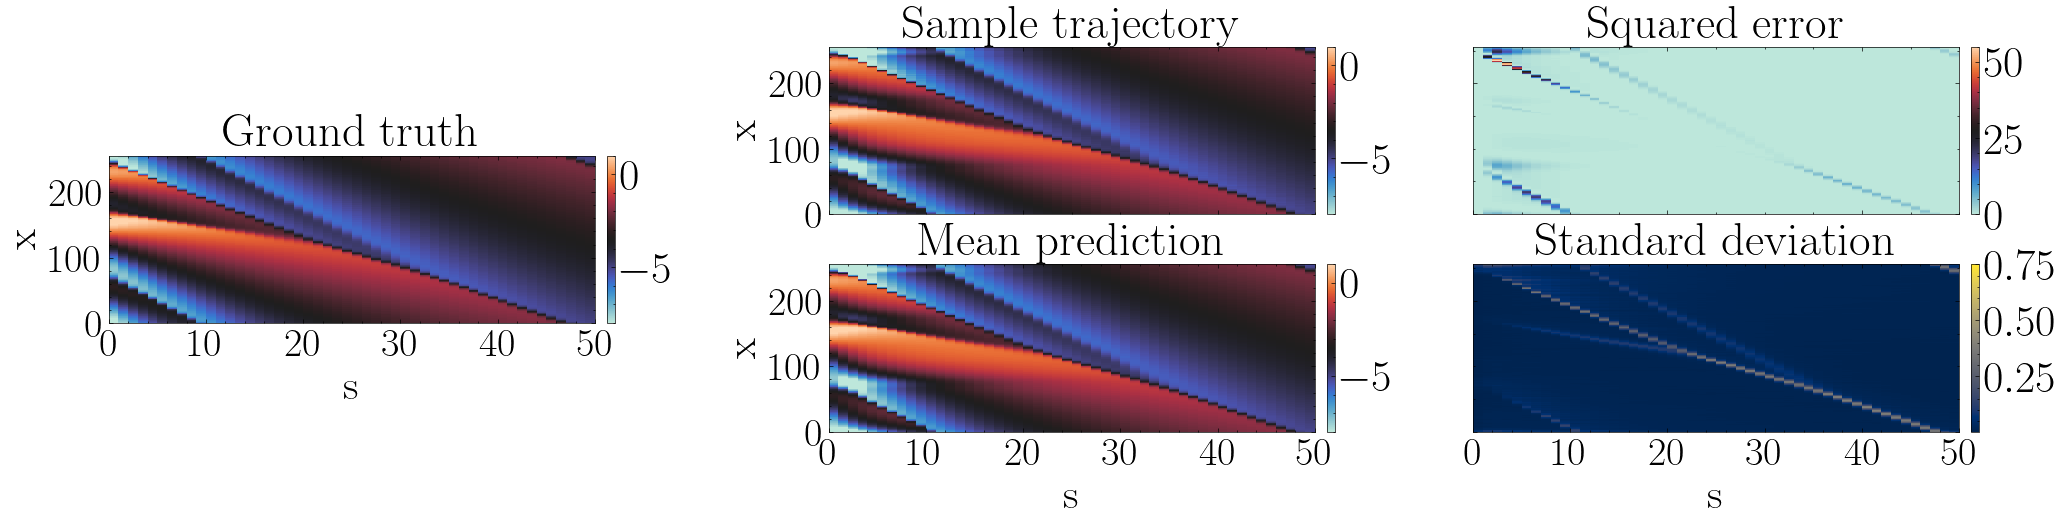

In [6]:
plot_predictions(truth, normal, "normal")

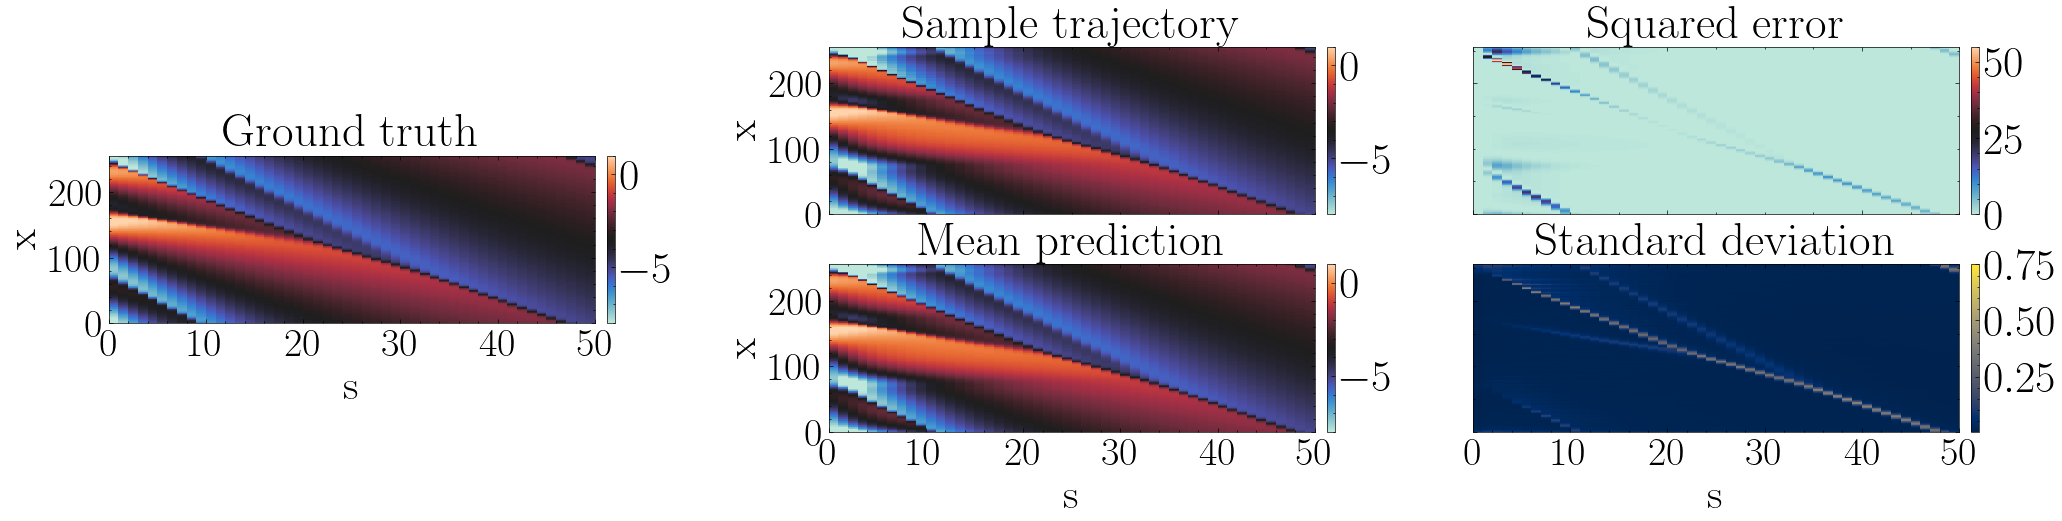

In [7]:
plot_predictions(truth, mixednormal, "mixednormal")

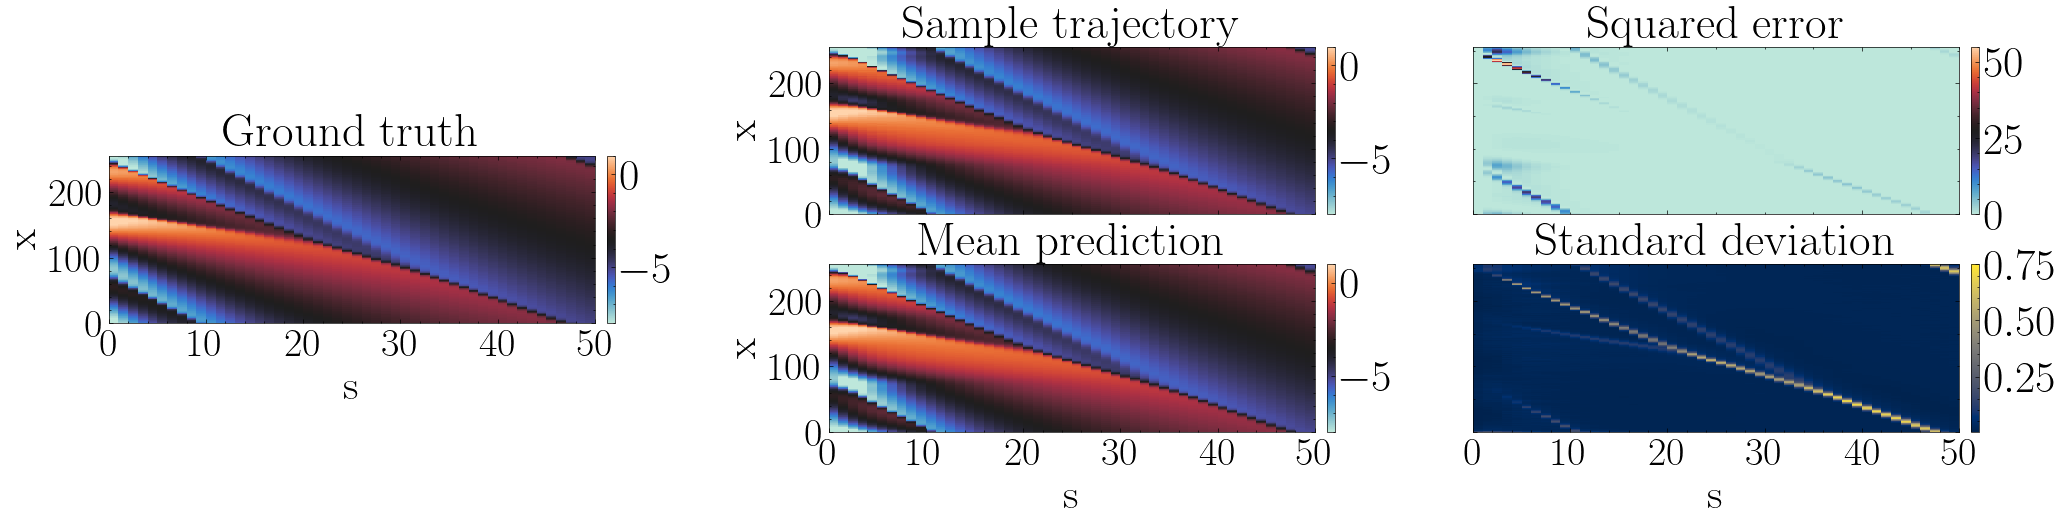

In [8]:
plot_predictions(truth, mvnormal, "mvnormal")

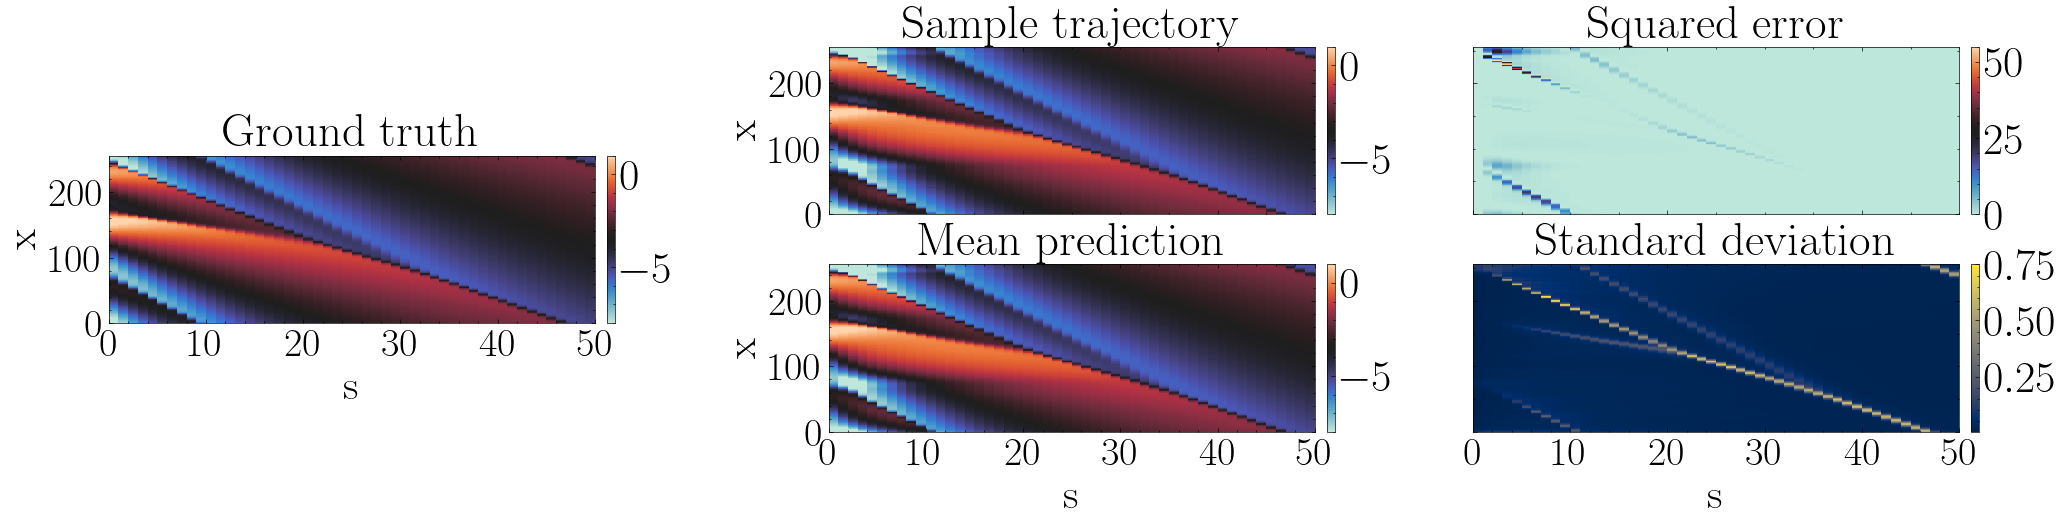

In [9]:
plot_predictions(truth, sample, "sample")

# 1D trajectories

In [4]:
lw = 3.5
plt.style.use(["science", "grid"])
b = 0

In [28]:
def plot_marginals(truth, model, name, steps = [10,20,25, 30, 40]):
  x = np.arange(256)
  fig, axs = plt.subplots(1,len(steps), figsize = (25,2.5), sharex=True, sharey=True)

  for i, t in enumerate(steps):
      axs[i].plot(x,truth[b,0,t+2], color = "darkred", lw = lw, label = "Ground Truth")
      axs[i].set_title(rf"$s = {t}$", fontsize = titlesize)

      axs[i].plot(x,model[b,0,:,t].mean(axis = -1), "--", color = "darkblue", lw = lw , label = "Mean prediction")
    #  axs[1,i].set_title(rf"Predicted mean ($t = {t}$)", fontsize = titlesize)

      # Plot upper and lower 0.95 CI
      upper = np.quantile(model[b,0,:,t], 0.975, axis = -1)
      lower = np.quantile(model[b,0,:,t], 0.025, axis = -1)
      axs[i].fill_between(x, lower, upper, color = "darkblue", alpha = 0.5)

      axs[i].set_xlabel(r"$x$", fontsize = axissize)   # bottom left


  for ax in axs.ravel():
      ax.tick_params(axis="both", which="major", labelsize=ticksize)
      ax.set_xticks([0,50,100,150,200,250])
      #ax.set_yticks([-2,-1,0,1,2])
      #ax.set_ylim([-2.5,2.5])

  axs[0].set_ylabel(r"$u(s,x)$", fontsize = axissize)   # bottom left
  handles, labels = axs.flat[0].get_legend_handles_labels()
  # Legend below
  fig.legend(handles, labels, bbox_to_anchor=(0.5, -0.15), loc="upper center", fontsize = legendsize, ncol = 3, frameon=True)

  plt.savefig(f"plots/Burgers_marginal_{name}.pdf", bbox_inches = "tight")

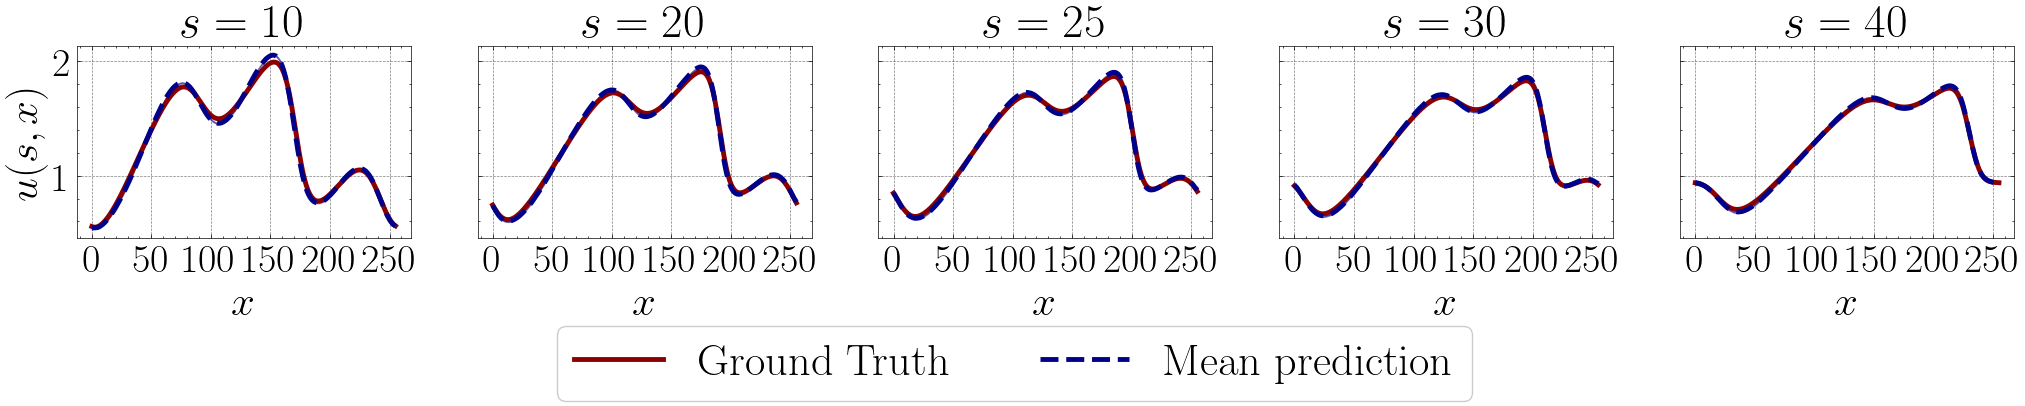

In [29]:
plot_marginals(truth, normal, "normal")

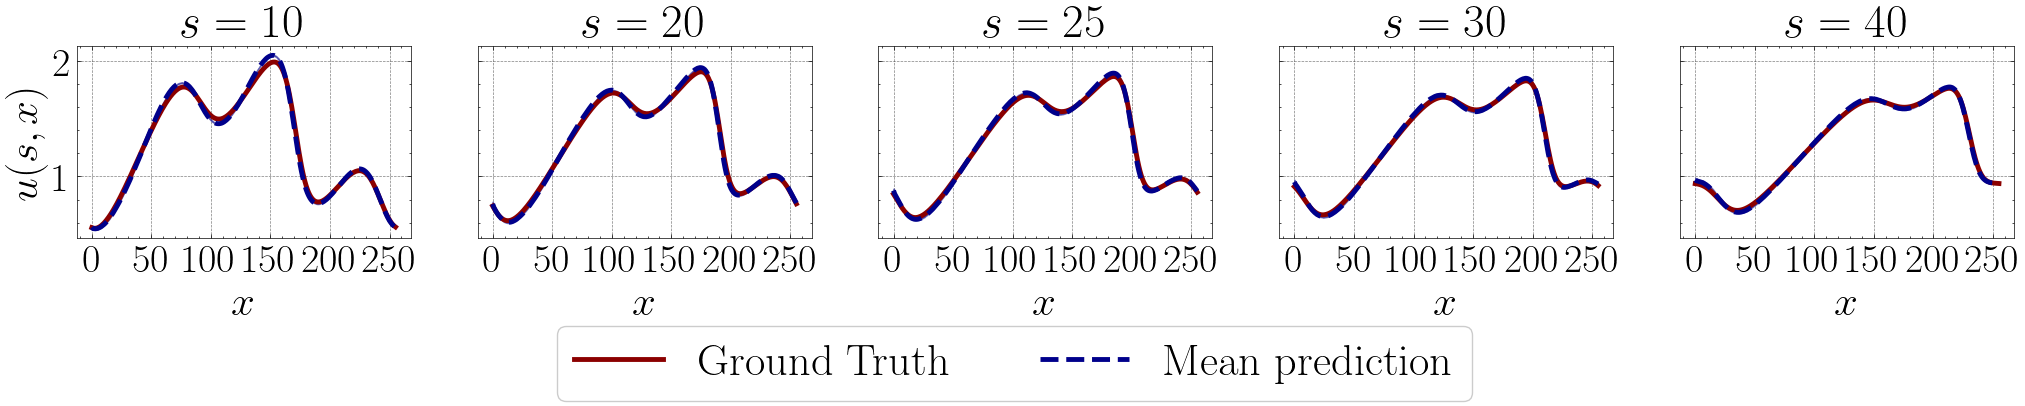

In [30]:
plot_marginals(truth, mixednormal, "mixednormal")

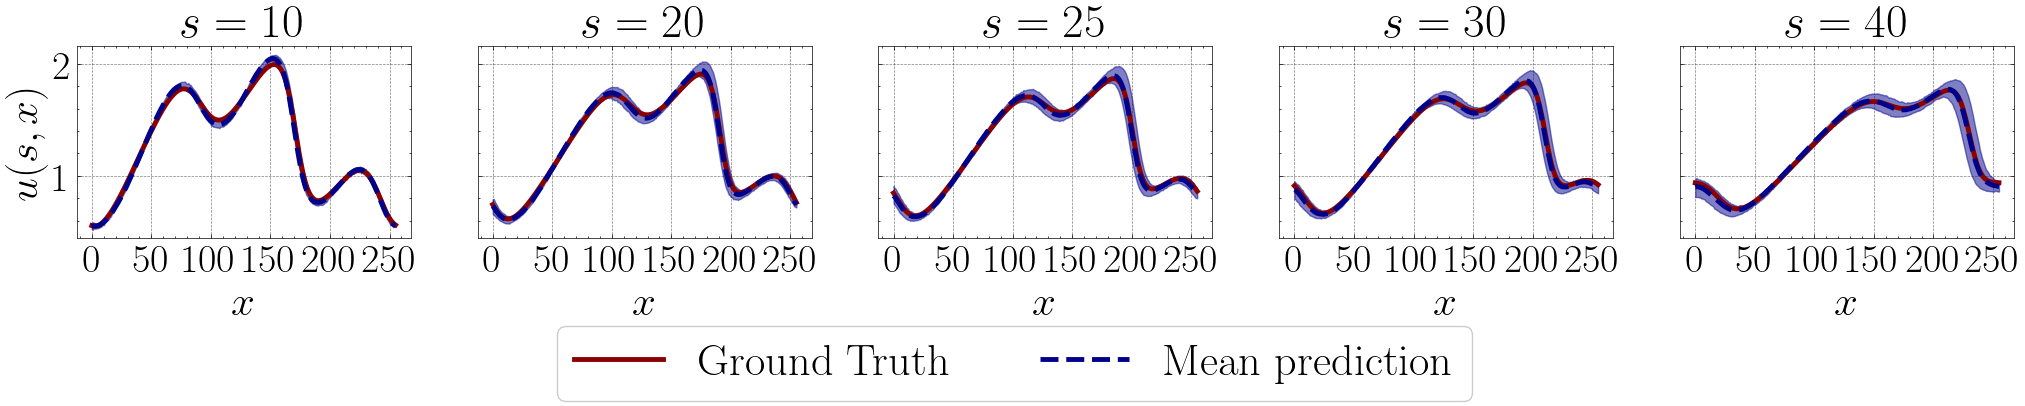

In [31]:
plot_marginals(truth, mvnormal, "mvnormal")

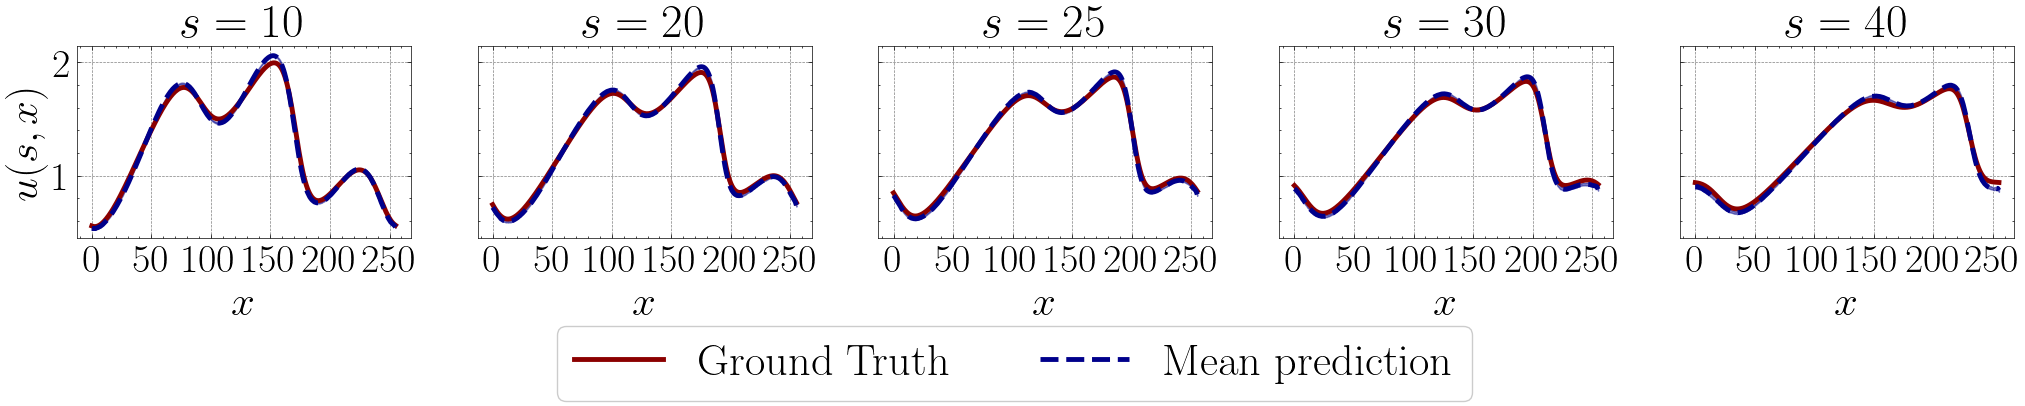

In [32]:
plot_marginals(truth, sample, "sample")